# Hands-On: Building a CNN Model with PyTorch

In [ ]:
# 1. Load Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

In [ ]:
# 2. Load and Preprocess Data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

In [ ]:
# 3. Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1,padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = CNN()

In [ ]:
# 4. Set Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the selected device
model = CNN().to(device)

# Train the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(3):
    running_loss = 0.0
    for images, labels in trainloader:
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Using device: cuda
Epoch 1, Loss: 0.15347843305386508
Epoch 2, Loss: 0.04551859845398371
Epoch 3, Loss: 0.030703553696411715


In [ ]:
# 5. Evaluate Performance
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.02%


# CNN Prediction & Explainability with Gemini API

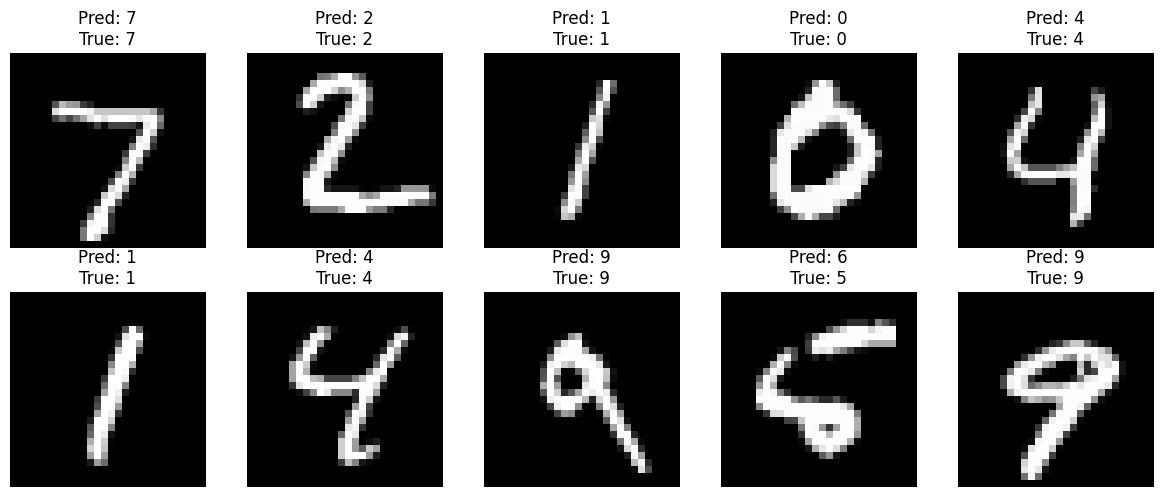

In [ ]:
# 1. Make a Prediction on an Image
import random
import matplotlib.pyplot as plt

# MNIST class labels
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

dataiter = iter(testloader)
images, labels = next(dataiter)

# Move to device
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Move images to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted_label = predicted.cpu()

# Display 10 images with predicted and actual labels
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy
    img = (img * 0.5) + 0.5  # Unnormalize

    axes[i].imshow(img, cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")

plt.tight_layout()
plt.show()

In [ ]:
import google.generativeai as genai

API_KEY = "[GEMINI-API-KEY]"
genai.configure(api_key=API_KEY)
modelai = genai.GenerativeModel("gemini-pro")
prompt = f"The CNN model predicted the digit {predicted_label[0]} for an image. Explain why it might have made this prediction."
response = modelai.generate_content(prompt)
if response and hasattr(response, "text"):
    print("Gemini Explanation:", response.text.strip())
else:
    print("Error: No valid response from Gemini API.")

Gemini Explanation: **Possible reasons why the CNN model predicted the digit 7:**

* **Visual Similarity:** The image may have contained features that are similar to the digit 7, such as a vertical stroke and a horizontal line at the bottom. The model might have mistaken these features for the number 7.

* **Edge Detection:** CNNs are good at detecting edges, which are important features for recognizing digits. The image may have had strong edges that resembled the edges of a 7, leading the model to classify it as such.

* **Contextual Information:** If the image was part of a sequence or dataset with other images of 7s, the model might have inferred the correct prediction based on the surrounding context.

* **Bias in the Training Data:** The training data used to build the CNN model may have contained more images of 7s than other digits, leading to a bias towards predicting 7s.

* **Overfitting:** The model may have overfit to the training data and learned specific patterns that are 

3. Explainability<br>
A. Compare explanations for correct vs. incorrect predictions.<br>
  The CNN is able to identify key features through optimizaation of the convolutional layers, such as a vertical stroke and horizontal stroke associated with (in this case) the number 7. It's also capable of recognizing edge patterns and implementing contextual information from previous exposure to similar images with the same digit. These factors explain the models capacity for a correct classification.<br>
  For incorrect predictions, the model could be prompted to classify an image as a 7 simply because there were a disproportianate numeber of 7's in the training data, which indicates a bias in that data. Also, this specific image may have contained specific feature variations that were not present in the training set and the model, therefore, did not learn how to recognize them. Other potential causes for incorrect classifications could be overfitting to the training data, extraneous noise due to poor image quality, or improper setup of the CNN model such as insuffcient layers or kernel size that prevented the model from appropriately learning the complex features necessary to distinguish classes.<br><br>
B. Discuss how LLMs enhance model interpretability.<br>
  The inner workings of the model utilizes complex mathematics that are not easily interpretable. LLMs bridge this gap with, for example, CNN models by translating the process of feature learning and edge detection in terms easily understood. This can be done in a general sense for how the model operates to form predictions, or in a specific sense for describing the features identified in a single sample that were used to make that individual prediction. Additionally, an LLM can provide a straightforward explanation that outlines why any errors may have occurred and how to improve it's performance.<br><br>
C. Highlight the importance of explainability in AI applications.<br>
  Explainability is important for model transparency, which garners trust among users. This means that users will be able to understand how a particular model came to a decision, which will make them more accepting of the outcome rather than viewing AI as a "black box." A thorough understanding of the outcome also gives users a sense of the model's accuracy and integrity as it's explainations will highlight any potential biases in it's inference capabilities. Bias would raise ethical concerns, especially when used in high-stakes environments where noncompliance could have a significant impact. On that same note, the model's explainability can simultaneously alleviate some of these concerns by providing recommendations to developers for performance improvement.

In [ ]:
# Load CIFAR-10 data
transform2 = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform2)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=64,shuffle=True)

testset2 = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform2)
testloader2 = torch.utils.data.DataLoader(testset2, batch_size=64,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# 1. Modify CNN to Handle CIFAR-10
class CIFARCNN(nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model_cifar = CIFARCNN()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the selected device
model_cifar = CIFARCNN().to(device)

# 2. Train for 2 Epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cifar.parameters(), lr=0.001)
for epoch in range(2):
    running_loss = 0.0
    for images, labels in trainloader2:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cifar(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader2)}")

Using device: cuda
Epoch 1, Loss: 1.485488960047817
Epoch 2, Loss: 1.172115553446743


In [ ]:
# Evaluate Performance
correct = 0
total = 0
model_cifar.eval()
with torch.no_grad():
    for images, labels in testloader2:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cifar(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 61.06%


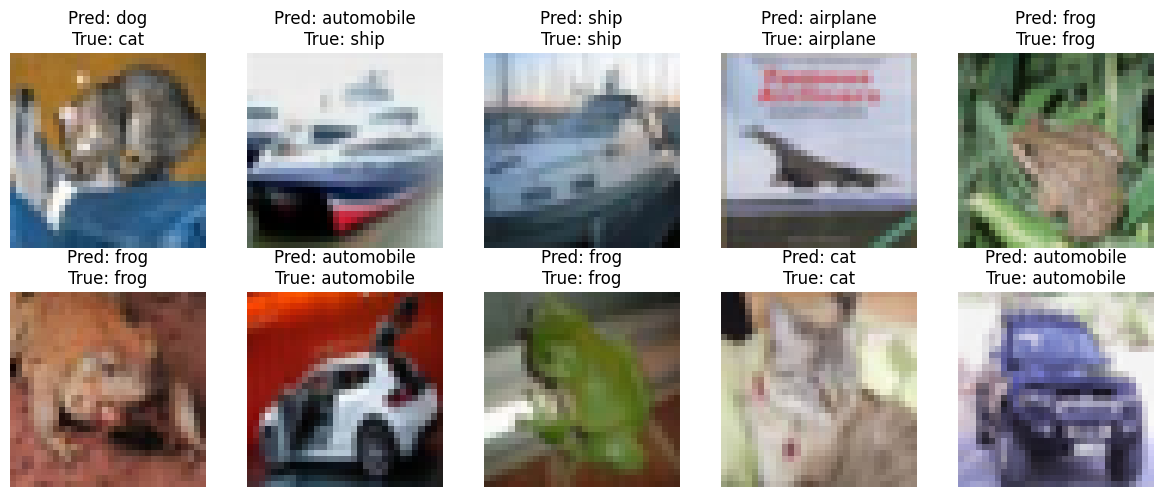

In [ ]:
# Make a Prediction on an Image
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of test images
dataiter = iter(testloader2)
images, labels = next(dataiter)

# Move to device
images, labels = images.to(device), labels.to(device)

# Get predictions
outputs = model_cifar(images)
_, predicted = torch.max(outputs, 1)

# Move images to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Display 10 images with predicted and actual labels
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy
    img = (img * 0.5) + 0.5  # Unnormalize

    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")

plt.tight_layout()
plt.show()

3. Compare MNIST vs. CIFAR-10 Model Complexity
The MNIST dataset are slightly smaller (28 x 28) than the CIFAR-10 data (32 x 32) and are only composed of grayscale images (1 channel), whereas CIFAR-10 contains color images (3 channel - RGB). This difference in image input allows for a simpler model structure to be built around prediction of MNIST images. This is demonstrated in the accuracy of the two CNN models (99% for MNIST vs 61% for CIFAR), each of which are composed of only two convolutional layers. The MNIST image compositions are also simpler in that they are only composed of digits 0-9, which have fewer and less diverse structural features for the model to learn. CIFAR-10 is composed of various real-world objects that have a higher variation in shape composition, edge structure, background diversity, and depth. A more complex CNN model would likely increase the accuracy on the CIFAR-10 data, but would be more computationally expensive and require longer training times. The increased complexity in the CIFAR-10 images make it more difficult for the CNN to generalize well to new images, and will likely require more advanced techniques, such as batch normalization, dropout, and data augmentation.